In [1]:
suppressPackageStartupMessages({
    library(here) # All paths relative to the git directory
    library(glmnet)
    library(ggplot2)
    library(patchwork)
    library(lubridate)
    library(dplyr)
    library(randomForest)
    library(provoc)
    theme_set(theme_bw())
})


# Deriving the Lineage Deconvolution Model

Suppose that, among all people with the COVID-19 disease (which is caused by the virus SARS-CoV-2), 20% of people are infected with lineage X and 80% are infected with lineage Y.

Now suppose that the definition of lineage X is based on mutations $m_1$ and $m_2$, whereas lineage Y has mutations $m_2$ and $m_3$ in its definition. Given that 20% of the population has lineage $X$ and mutation $m_1$ is part of lineage $X$ *only*, we would expect that 20% of the sequences we find in the wastewater have mutation $m_1$. 

However, mutation $m_2$ is in both lineages, so we would expect it to have frequency 20% + 80% = 100%.

This is what I call the central dogma of lineage deconvolution: The frequency of a mutation is expected to be the sum of the proportions of lineages to which it belongs.

Putting this in math terms, suppose that we have mutation frequency vector $(y_1, y_2, y_3)$. Define lineage $X$ as having mutations 1 and 2 but *not* 3: $L_X = (1, 1, 0)$, and similarly $L_Y = (0, 1, 1)$. Let $\beta = (\beta_X, \beta_Y)$ be the proportions of each lineage in the true population. The central dogma of lineage deconvolution implies the model $y = X\beta$, where $X$ is defined as:

$\begin{matrix}
    & X & Y\\
m_1 & 1 & 0\\
m_2 & 1 & 1\\
m_3 & 0 & 1
\end{matrix}$

This model $y = X\beta$ is just a linear model! We didn't choose it because it's easy, it came about from our assumptions about the data generating process.



## Beyond Linear Models (but still linear)

The linear model doesn't do a terrible job at estimating proportions. It's missing a few nice-to-haves, such as:

- The proportions must sum to 1
- The proportions must be positive

but otherwise it does okay.

We can also impose some regularization to the coefficients using ridge/LASSO/elasticnet, which is what many approaches do.

In the description above, I specified that it's the *expected value* of the the frequency that we are modelling. This means the model works for any generalized linear model with the identity link function. Specifically, the frequencies that we observe come from dividing the number of times a mutation was observed by the number of times a mutation *could have* been observed. This sounds an awful lot like a Binomial GLM. However, note that the *expected value* of the frequency is linear, so we're dealing with an identity link function in a Binomial GLM (as long as we can restrict the parameters)! 

This is the model that I have implemented in my ProVoC R package:

$$
y \sim \text{Binom}(prob = X\beta, size = coverage)
$$



# Data Analysis

In the following cell, I import data that I've pre-processed elsewhere (contact me for access). The original data contain many samples; for now we'll just focus on one of them.

- `coco` contains a lot of different samples
- `j1` is a single wastewater sample.

In [2]:
all_data <- read.csv(here("data", "PRJNA1042787_processed.csv.gz"))
all_data$mutation <- provoc::parse_mutations(all_data$label)
head(all_data) |> print()

table(all_data$date) |> print()


  position            label    mutation    frequency coverage count         sra       date                sample_name avg_spot_len
1    22204 +22205.GAGCCAGAA ins:22205:9 0.9477611940     5360  5080 SRR26876975 2022-01-17 Viikinmaki_17012022_dil1-5          502
2    25699    +25700.CCCCCC ins:25700:6 0.0000000000    35018     0 SRR26876975 2022-01-17 Viikinmaki_17012022_dil1-5          502
3    25703    +25704.CCCCCT ins:25704:6 0.0000000000    35015     0 SRR26876975 2022-01-17 Viikinmaki_17012022_dil1-5          502
4    11074         -11075.1 del:11075:1 0.0338873464    26293   891 SRR26876975 2022-01-17 Viikinmaki_17012022_dil1-5          502
5    11082         -11083.1 del:11083:1 0.0002282931    26282     6 SRR26876975 2022-01-17 Viikinmaki_17012022_dil1-5          502
6    11282         -11283.9 del:11283:9 0.9147274381    18693 17099 SRR26876975 2022-01-17 Viikinmaki_17012022_dil1-5          502
      bases   bioproject ww_population
1 781146136 PRJNA1042787        860000
2 781

- `mutation` is the mutation name, which won't be particularly useful here but may be of importance to practitioners.
- `sample` is a unique identifier.
    - All entries with the same sample identifier (`sra`) have the same values for `date`.
- `date` is date
- `count` is the number of times the mutation was observed in the wastewater
- `coverage` is the number of times that a mutation *could have been observed*.
- `frequency` is count/coverage.
    - Ideally, coverage will be considered, but this is not necessary for now.

Note that the data were processed in such a way that all mutations are present in all samples. In the raw data, there were mutations not observed on some days which had to be added into the data as a count of 0 and there were mutations that were only observed on a few days, which were removed.


# Lineage Definitions

**Lineages are not defined as a list of mutations.** Lineages are defined by their placement on a phylogenetic tree, which is impossible to do with wastewater samples. Instead, we approximate the definitions as a list of mutations based on what we know about clinical samples within each lineage classifications.

There are many ways of defining lineages. My `provoc` package has ones from the [pango constellations](https://github.com/cov-lineages/constellations) repo built-in. These are no longer updated, so they're here for historical convenience. I've found better results with other definitions (these constellations were never meant to be used this way).

In [3]:
astro <- astronomize()

rownames(astro)

 [1] "A.23.1"          "A.23.1+E484K"    "AV1"             "AY.4.2"          "AY.4"            "B.1.1.318"       "B.1.1.529"      
 [8] "B.1.1.7"         "B.1.1.7+E484K"   "B.1.351"         "B.1.427"         "B.1.429"         "B.1.525"         "B.1.526"        
[15] "B.1.617.1"       "B.1.617.2"       "B.1.617.2+K417N" "B.1.617.3"       "B.1.621"         "BA.1"            "BA.2"           
[22] "BA.3"            "BA.4"            "BA.5"            "C.37"            "P.1"             "P.2"             "P.3"            
[29] "XBB-parent1"     "XBB-parent2"     "XBB.1.16"        "XBB.1.5"         "XBB.1"           "XBB"             "XE-parent1"     
[36] "XE-parent2"      "XE"             

In [4]:
# provoc::fuse() joins the lineage definitions according to the mutation names
# It accounts for the case when lineages are identical after merging!
coco <- provoc::fuse(all_data, astro)

names(coco) |> print()
coco |> select(mutation, frequency, coverage, count, starts_with("lin")) |> head()

 [1] "position"            "label"               "mutation"            "frequency"           "coverage"           
 [6] "count"               "sra"                 "date"                "sample_name"         "avg_spot_len"       
[11] "bases"               "bioproject"          "ww_population"       "lin_A.23.1"          "lin_A.23.1+E484K"   
[16] "lin_AV1"             "lin_AY.4"            "lin_B.1.1.318"       "lin_B.1.1.529"       "lin_B.1.1.7"        
[21] "lin_B.1.1.7+E484K"   "lin_B.1.427"         "lin_B.1.429"         "lin_B.1.525"         "lin_B.1.526"        
[26] "lin_B.1.617.1"       "lin_B.1.617.2"       "lin_B.1.617.2+K417N" "lin_B.1.617.3"       "lin_B.1.621"        
[31] "lin_BA.1"            "lin_BA.2"            "lin_BA.3"            "lin_BA.4"            "lin_BA.5"           
[36] "lin_C.37"            "lin_P.3"             "lin_XBB.1"           "lin_XE-parent1"      "lin_XE-parent2"     
[41] "lin_XE"             


     mutation  frequency coverage count lin_A.23.1 lin_A.23.1+E484K lin_AV1 lin_AY.4 lin_B.1.1.318 lin_B.1.1.529 lin_B.1.1.7
1 ins:22205:9 0.94776119     5360  5080          0                0       0        0             0             0           0
2 del:11288:9 0.02845985    18693   532          0                0       0        0             0             0           0
3 del:21633:9 0.02516993    20302   511          0                0       0        0             0             0           0
4 del:21765:6 0.93217347     7932  7394          0                0       0        0             0             0           0
5 del:21987:9 0.94854369     5150  4885          0                0       0        0             0             0           0
6 del:22029:6 0.03010878     5148   155          0                0       0        1             0             0           0
  lin_B.1.1.7+E484K lin_B.1.427 lin_B.1.429 lin_B.1.525 lin_B.1.526 lin_B.1.617.1 lin_B.1.617.2 lin_B.1.617.2+K417N lin_B.1.6

# Fitting a model

A basic linear model for `frequency` (with no intercept term) will output coefficients that represent the proportions of each variant.

In [5]:
lm_estimator <- function(sample) {
    mylm <- lm(frequency ~ -1 + lin_B.1.617.2 + lin_BA.1 + lin_BA.2 + lin_BA.3, 
        data = coco[coco$sra == sample, ])
    data.frame(est = as.numeric(t(coef(mylm))), 
        variant = c("B.1.617.2", "BA.1", "BA.2", "BA.3"),
        model = "lm", 
        date = coco$date[coco$sra == sample][1])
}

glm_logit_estimator <- function(sample) {
    myglm_logit <- try(
        glm(cbind(count, coverage - count) ~ -1 + lin_B.1.617.2 + lin_BA.1 + lin_BA.2 + lin_BA.3,
            data = coco[coco$sra == sample, ], 
            family = binomial(link = "logit")),
        silent = TRUE)
    
    if (class(myglm_logit)[1] == "try-error") {
        ests <- rep(NA, 4) 
    } else {
        ests <- as.numeric(exp(t(coef(myglm_logit))) /
                (1 + exp(t(coef(myglm_logit)))))
    }
    data.frame(
        est = ests, 
        variant = c("B.1.617.2", "BA.1", "BA.2", "BA.3"),
        model = "glm_logit", 
        date = coco$date[coco$sra == sample][1])
}

glm_id_estimator <- function(sample) {
    myglm_id <- try(
        glm(cbind(count, coverage - count) ~ -1 + lin_B.1.617.2 + lin_BA.1 + lin_BA.2 + lin_BA.3,
            data = coco[coco$sra == sample, ], 
            family = binomial(link = "identity")),
        silent = TRUE)
    if (class(myglm_id)[1] == "try-error") {
        ests <- rep(NA, 4)
    } else {
        ests <- as.numeric(t(coef(myglm_id)))
    }
    data.frame(
        est = ests, 
        variant = c("B.1.617.2", "BA.1", "BA.2", "BA.3"),
        model = "glm_id", 
        date = coco$date[coco$sra == sample][1])
}

provoc_estimator <- function(sample) {
    provoc_res <- provoc(count / coverage ~ B.1.617.2 + BA.1 + BA.2 + BA.3,
        data = coco |> select(-starts_with("lin")) |> filter(sra == sample),
        lineage_defs = astro
    )
    data.frame(
        est = provoc_res$rho,
        variant = provoc_res$lineage,
        model = "provoc", 
        date = coco$date[coco$sra == sample][1]
    )
}

lasso_estimator <- function(sample){
    mydata <- coco[coco$sra == sample, ]
    X <- as.matrix(mydata[, c("lin_B.1.617.2", "lin_BA.1", "lin_BA.2", "lin_BA.3")])
    y <- mydata[, "frequency"]
    lasso_cv <- try(cv.glmnet(X, y, intercept = FALSE, 
        standardize = FALSE, alpha = 1))
    if(class(lasso_cv)[1] == "try-error") {
        ests <- rep(NA, 4)
    } else {
        lasso <- glmnet(X, y, intercept = FALSE, standardize = FALSE,
            alpha = 1, lambda = lasso_cv$lambda.1se)
        ests <- as.numeric(coef(lasso)[-1])
    }
    data.frame(
            est = ests, 
            variant = c("B.1.617.2", "BA.1", "BA.2", "BA.3"),
            model = "lasso", 
            date = coco$date[coco$sra == sample][1])
}

rf_estimator <- function(sample) {
    myrf <- randomForest(frequency ~ lin_B.1.617.2 + lin_BA.1 + lin_BA.2 + lin_BA.3, 
        data = coco[coco$sra == sample, ])
    pred_mat = diag(4)
    colnames(pred_mat) <- c("lin_B.1.617.2", "lin_BA.1", 
        "lin_BA.2", "lin_BA.3")
    preds <- predict(myrf, 
        newdata = as.data.frame(pred_mat))
    data.frame(est = preds, 
        variant = c("B.1.617.2", "BA.1", "BA.2", "BA.3"),
        model = "rf", 
        date = coco$date[coco$sra == sample][1])
}

all_res <- bind_rows(
    lm_estimator(coco$sra[1]),
    glm_logit_estimator(coco$sra[1]),
    glm_id_estimator(coco$sra[1]),
    lasso_estimator(coco$sra[1]),
    rf_estimator(coco$sra[1]),
    provoc_estimator(coco$sra[1])
)
rownames(all_res) <- NULL
all_res |> print()


          est   variant     model       date
1  0.10984041 B.1.617.2        lm 2022-01-17
2  0.91273001      BA.1        lm 2022-01-17
3  0.03490054      BA.2        lm 2022-01-17
4  0.06664160      BA.3        lm 2022-01-17
5  0.12942199 B.1.617.2 glm_logit 2022-01-17
6  0.97250669      BA.1 glm_logit 2022-01-17
7  0.07681057      BA.2 glm_logit 2022-01-17
8  0.48587640      BA.3 glm_logit 2022-01-17
9          NA B.1.617.2    glm_id 2022-01-17
10         NA      BA.1    glm_id 2022-01-17
11         NA      BA.2    glm_id 2022-01-17
12         NA      BA.3    glm_id 2022-01-17
13 0.00000000 B.1.617.2     lasso 2022-01-17
14 0.49114788      BA.1     lasso 2022-01-17
15 0.00000000      BA.2     lasso 2022-01-17
16 0.00000000      BA.3     lasso 2022-01-17
17 0.26897270 B.1.617.2        rf 2022-01-17
18 0.76110405      BA.1        rf 2022-01-17
19 0.25868891      BA.2        rf 2022-01-17
20 0.52282955      BA.3        rf 2022-01-17
21 0.09694797 B.1.617.2    provoc 2022-01-17
22 0.87367

Warning message:
Removed 4 rows containing missing values or values outside the scale range (`geom_point()`). 


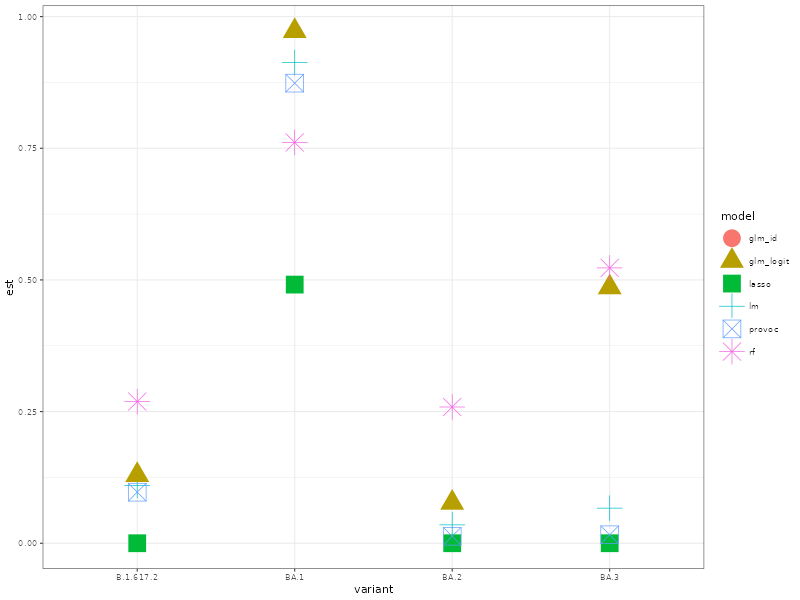

In [6]:
ggplot(all_res) +
    aes(x = variant, y = est, colour = model, shape = model) +
    geom_point(size = 8)

The coefficients for the linear model above indicate that 50\% of this sample were B.1.617.2, with trace amounts of the other variants. Note that these don't sum to 1 - this is okay! I like that the model allows for unknown variants. What I *don't* want is coefficients whose sum is greater than 1.

The glm and the lasso models all indicate a prevalence of 0.3, or 30%, which is quite different from the linear model! The GLM models incorporate the variance due to the coverage (which will be significant in this case), but the lasso picks up on this value despite being a linear model!

# Fit to All Data

To compare the results, we'll look at all of the data in the set. Note that there is no ground truth here; these data are messy, and the results depend on how I defined the `lin_*` columns. Also note that there is a lot of data and this takes a minute or two.


In [7]:
all_samples <- unique(coco$sra)

mean_estimator <- function() {
    b117 <- with(subset(coco, lin_B.1.1.7 == 1), aggregate(frequency, list(date = date), mean))
    b117$variant <- "B.1.617.2"
    b117$model <- "mean"
    b16172 <- with(subset(coco, lin_B.1.617.2 == 1), aggregate(frequency, list(date = date), mean))
    b16172$variant <- "BA.1"
    b16172$model <- "mean"
    b1351 <- with(subset(coco, lin_BA.1 == 1), aggregate(frequency, list(date = date), mean))
    b1351$variant <- "BA.2"
    b1351$model <- "mean"
    p1 <- with(subset(coco, lin_BA.3 == 1), aggregate(frequency, list(date = date), mean))
    p1$variant <- "BA.3"
    p1$model <- "mean"

    res <- do.call(rbind, list(b117, b1351, b16172, p1))
    colnames(res)[colnames(res) == "x"] <- "est"
    rownames(res) <- NULL
    res
}

all_ests <- suppressWarnings(bind_rows(lapply(all_samples, function(x) {
    bind_rows(
        lm_estimator(x),
        glm_logit_estimator(x),
        glm_id_estimator(x),
        #lasso_estimator(x),
        provoc_estimator(x),
        rf_estimator(x)
    )
})))

#all_ests <- bind_rows(all_ests, mean_estimator())


Warning messages:
1: Removed 56 rows containing missing values or values outside the scale range (`geom_line()`). 
2: Removed 56 rows containing missing values or values outside the scale range (`geom_point()`). 


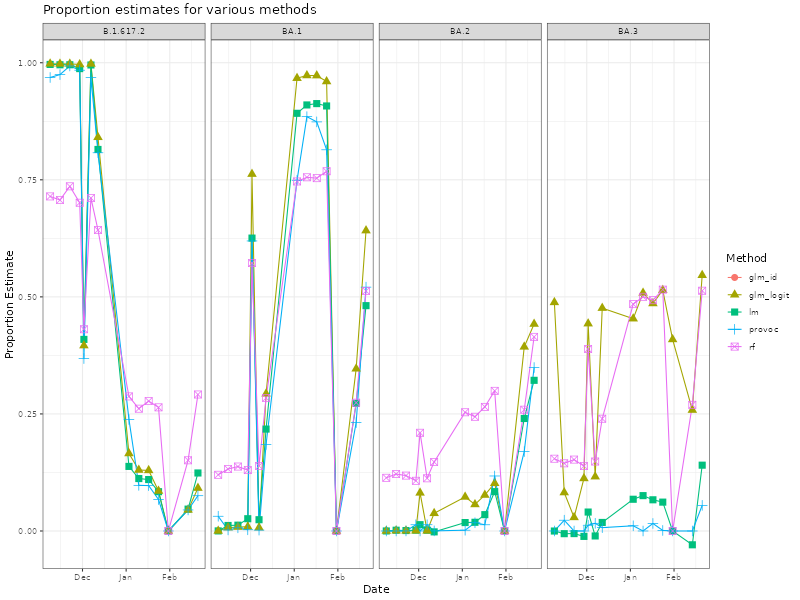

In [8]:
options(repr.plot.width=12, repr.plot.height=10)
ggplot(all_ests) +
    aes(x = ymd(date), y = est, colour = model, shape = model) +
    geom_line() + geom_point(size = 3) +
    facet_grid(~ variant) +
    labs(x = "Date", y = "Proportion Estimate",
        title = "Proportion estimates for various methods",
        colour = "Method", shape = "Method")


From these results, it appears that `lm` results in the highest estimates, `lasso` are regularized, and both binomial `glm` models have the lowest estimates with generally comparable results regardless of link function.

It is also extremely clear that the proportions do appear to vary smoothly over time!

Some other noteworthy points:

- `lm` produces negative coefficients! The other methods don't seem to have this problem, although I can't think of a technical reason for this.
- `lasso` seems to have set `BA.1` and `P.1` to 0 for all of the samples, which is nice.
- `glm_logit` has random spikes for `BA.1` and `BA.3`, even though they seem to have a 0 coefficient.
- The mean estimator tends to be higher than the others. 
- Random forest has trouble predicting 0s. 

# Model Diagnostics

We can easily look at the predictions of each model, but there are a lot of mutations and it's not immediately obvious what sort of pattern we expect. 

The following plots show the residuals, but separated by variant.

In [ ]:
mylm <- lm(frequency ~ -1 + lin_B.1.617.2 + lin_BA.1 + lin_BA.2 + lin_BA.3, 
        data = j1)
lm_res <- j1[, "frequency"] - predict(mylm)

g_B117 <- ggplot() + 
    aes(x = factor(j1[, "lin_B.1.617.2"]), y = lm_res) +
    geom_violin(draw_quantiles = c(0.25, 0.5, 0.75))
g_B1351 <- ggplot() + 
    aes(x = factor(j1[, "lin_BA.1"]), y = lm_res) + 
    geom_violin(draw_quantiles = c(0.25, 0.5, 0.75))
g_B16172 <- ggplot() + 
    aes(x = factor(j1[, "BA.2"]), y = lm_res) + 
    geom_violin(draw_quantiles = c(0.25, 0.5, 0.75))
g_P1 <- ggplot() + 
    aes(x = factor(j1[, "lin_BA.3"]), y = lm_res) + 
    geom_violin(draw_quantiles = c(0.25, 0.5, 0.75))

g_B117 + g_B1351 + g_B16172 + g_P1


There's possibly some bias in the predictions! Maybe? Hard to say.

The variants also have different numbers of mutations, which will affect the results:

In [ ]:
X <- j1[, startsWith(names(j1), "lin")]
apply(X, 2, mean) |> round(4) |> t()



# Modelling Approaches

## Better Models for Proportions

As noted, the *coefficients* of the linear model represent the proportions. That is, we're not trying to predict $y$, we're trying to predict $\beta$. 

I want to move into some machine learning algorithms (especially neural nets and random forests), but there isn't much room for non-linearity in the terms. Furthermore, the goal is to get good *parameter estimates*, not predictions. However, a creative use of the data will surely result in better proportion estimates.

## Models across space and time

The example above only used one sample. It's reasonable to assume that the proportion today is similar to the proportion yesterday, and that the proportion in one location is similar to the proportion in another. 

I'm working on Bayesian spatio-temporal models, but an application of a machine learning algorithm might outperform my models, both in prediction and computation time!

For a medium-complexity example see the `varying-coefficient-model.ipynb` notebook. This model assumes that the coefficients in the linear model follow a smooth function in time.

## Estimating the variants (clustering)

Finally, the proportions themselves can be estimated via a clustering algorithm (ignoring the "var\_\*" columns). This would likely need to incorporate space/time to ensure that clusters are stable over space/time, but could be an interesting approach.

I'm working on this with Non-Negative Matrix Factorization, but I'm also very intrigued by Self-Organizing Maps, which use neural networks for a clustering application.

The plots below demonstrate how a clustering algorithm might work: There is clearly a temporal pattern in the frequency of each mutation, and many mutations have the same temporal pattern. This idea of "mutations that share a temporal pattern" is exactly the sort of clustering idea I'm looking for, and it's clearly present in the data.

In [ ]:
ggplot(coco) +
    aes(x = ymd(date), y = frequency, colour = mutation) +
    geom_point() + 
    geom_smooth(se = FALSE, method = "loess", formula = y ~ x) + 
    theme(legend.position = "none") +
    labs(x = "Date", y = "Mutation Frequency")


From the plots above, it's clear that there are two "clusters"; that is, there's clearly a group of curves that are highest early on and then a group that are higher later, possibly with a third cluster that bumps up near the middle. From previous plots, we can recognize these as B.1.617.2, B.1.617.2, and possibly BA.3 or BA.1. 

There's also a random mutation with 50% prevalence across locations, and I'm not actually sure what that's about!